In [1]:
import requests
import sqlite3
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

### Connect to local SQLite3 database
Create a new table `earthquakes` with columns:
| magnitude | latitude | longitude | depth |
| --------- | -------- | --------- | ----- |

In [2]:
connection = sqlite3.connect("results/data.db")
cursor = connection.cursor()
cursor.execute("DROP TABLE IF EXISTS earthquakes")
cursor.execute(
    "CREATE TABLE earthquakes(magnitude REAL, latitude REAL, longitude REAL, depth REAL)"
)

### Store data into database
Read data from USGS API and store each earthquake's features into the database.

In [3]:
earthquakes = requests.get('https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.geojson').json()["features"]

data = [(e["properties"]["mag"], *e["geometry"]["coordinates"]) for e in earthquakes]
cursor.executemany("INSERT INTO earthquakes VALUES(?, ?, ?, ?)", data)
connection.commit()

### Load data into DataFrame
Read `earthquakes` table from SQLite database into a Pandas DataFrame object

In [4]:
# Fetch data from SQLite3 database into a DataFrame
df = pd.read_sql_query('SELECT * FROM earthquakes', connection)
df.head()

,magnitude,latitude,longitude,depth
0,2.27,-115.902000,33.056332,2.16
1,0.88,-122.807663,38.824333,3.23
2,0.93,-122.768669,38.787666,2.31
3,0.63,-122.881836,38.834167,1.93
4,0.90,-117.368100,37.276800,7.40


### Data cleaning
1. We first need to check if any data is missing. In this dataset, all data is present, so no imputation needs to be done.
1. Some earthquakes have a negative magnitude. These are not felt by humans, and so we can remove them.

In [5]:
print("NA Values:")
df.isna().sum()

NA Values:


magnitude    0
latitude     0
longitude    0
depth        0
dtype: int64

In [6]:
df = df[df["magnitude"] > 0]

### Exploratory Analysis
Understand underlying relationships between the data.

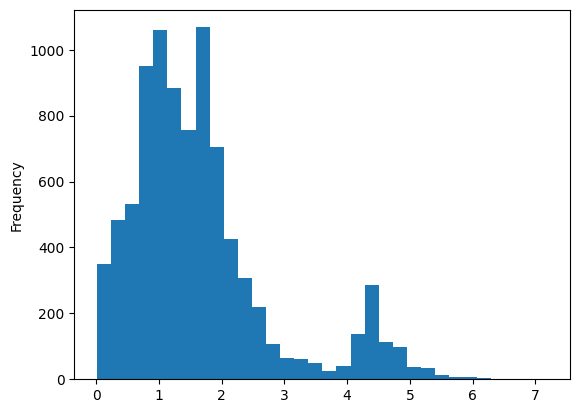

In [7]:
df["magnitude"].plot(kind='hist', bins=32)
plt.show()

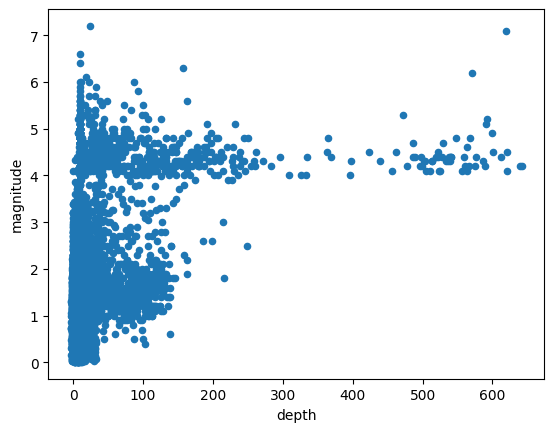

In [8]:
df.plot(x='depth', y='magnitude', kind='scatter')
plt.show()

### Plot earthquakes on map
Using GeoPandas and Matplotlib, we can visualize the location of each earthquake on a 2D map.
What's interesting to note here, is that the earthquakes seem to line up precisely with the boundaries
of tectonic plates.

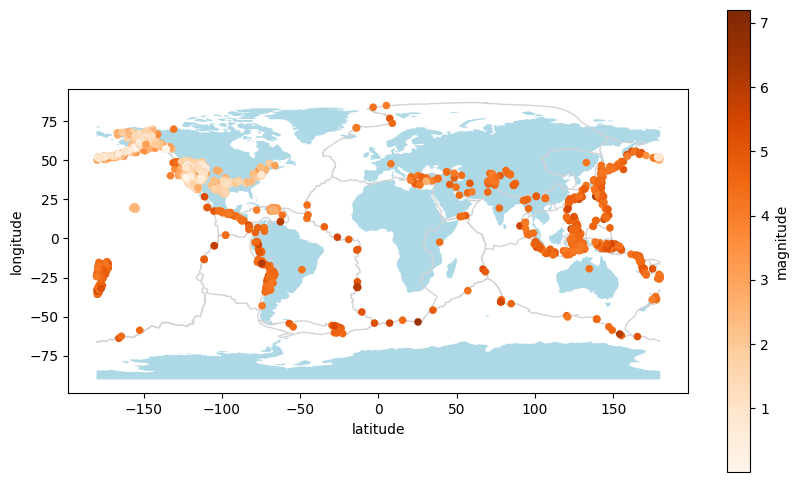

In [9]:
countries = gpd.read_file(geodatasets.get_path("naturalearth.land"))
tectonic_plates = gpd.read_file("tectonic/tectonic_plates.shp")

figure, ax = plt.subplots(figsize=(10, 6))
countries.plot(color="lightblue", ax=ax, zorder=1)
tectonic_plates.plot(color="lightgrey", linewidth=1, ax=ax, zorder=2)
df.plot(x='latitude', y='longitude', c='magnitude', colormap='Oranges', kind='scatter', ax=ax, zorder=3)
plt.show()

### Calculate distances to closest plate boundary
Here, we show that most earthquakes lie close to a tectonic plate boundary. Specifically, 75% of earthquakes
are within 6.68 degrees of a plate boundary.

In [10]:
distances = []
for _, (_, lat, lon, _) in df.iterrows():
    point = Point(lat, lon)
    distances.append(np.min(tectonic_plates.distance(point)))

df = df.assign(distance_to_closest_plate_boundary=distances)
df.head()

,magnitude,latitude,longitude,depth,distance_to_closest_plate_boundary
0,2.27,-115.902000,33.056332,2.16,0.199018
1,0.88,-122.807663,38.824333,3.23,0.558551
2,0.93,-122.768669,38.787666,2.31,0.562608
3,0.63,-122.881836,38.834167,1.93,0.510424
4,0.90,-117.368100,37.276800,7.40,2.801666


In [11]:
df['distance_to_closest_plate_boundary'].describe()

count    8828.000000
mean        7.040509
std        10.933156
min         0.000038
25%         0.563106
50%         2.259237
75%         6.666846
max        35.105888
Name: distance_to_closest_plate_boundary, dtype: float64

### Predict magnitude of Earthquake using RandomForestRegressor
Here, we train a Random forest model to predict the magnitude of an earth quake given the other features.
We use a standard train test split of 75:25 to validate the model.

In [12]:
train, test = train_test_split(df, test_size=0.25, random_state=42)

x_train = train.drop(columns=['magnitude'])
y_train = train['magnitude']

x_test = test.drop(columns=['magnitude'])
y_test = test['magnitude']

In [13]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=100)
rf.fit(x_train, y_train)

RandomForestRegressor(min_samples_leaf=100)

In [14]:
error = np.square((rf.predict(x_test) - y_test)).mean()
error

np.float64(0.3406375211002516)

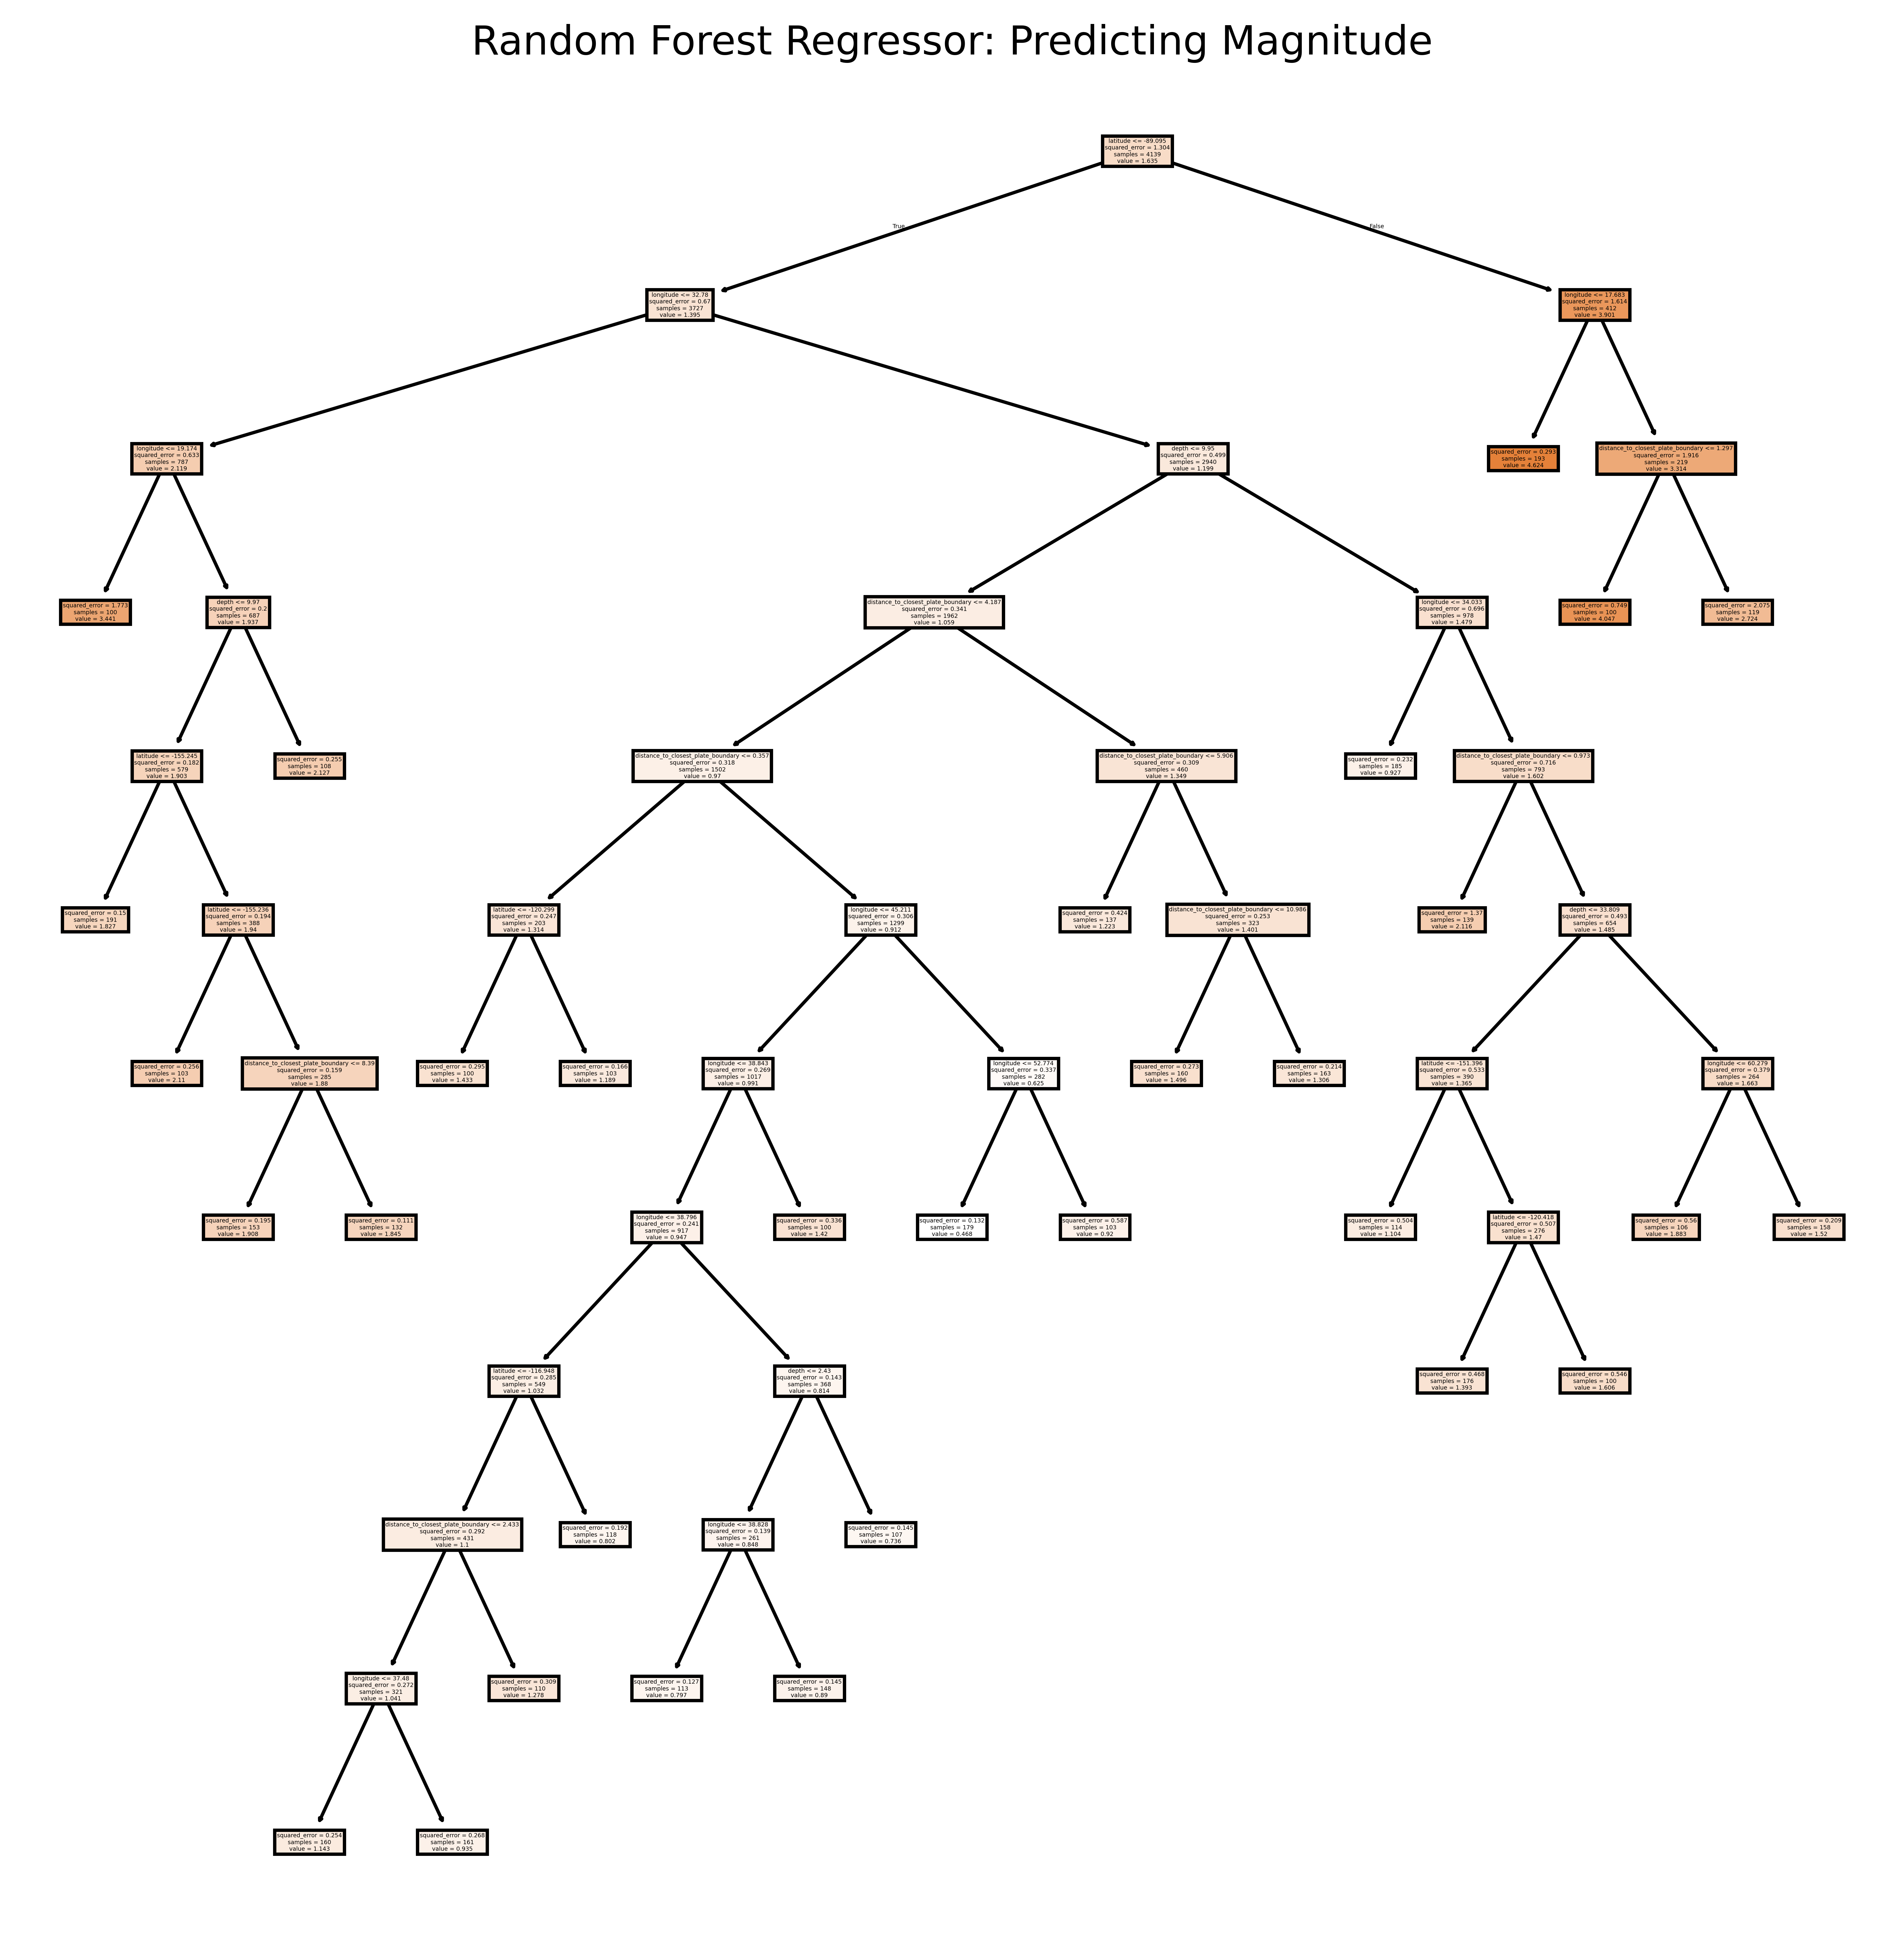

In [15]:
fig, axes = plt.subplots(figsize = (10, 10), dpi=800)
plot_tree(rf.estimators_[0], feature_names=x_train.columns, filled=True)
plt.title('Random Forest Regressor: Predicting Magnitude')
plt.savefig('results/rf_regressor.png')
plt.show()